# Lab 05 : Problem Solving

This lab involves a more open-ended study of a system. Obtaining a solution will require several numerical techniques we have encountered so far, including integration, solving differential equations, and optimization.

## Initialization

As always you should add initialization to the top of your notebook.

In [2]:
### BEGIN SOLUTION
import numpy as np
import scipy.integrate as integ
import scipy.optimize as opt
import scipy.interpolate as interp
import matplotlib.pyplot as plt
%matplotlib inline
# Globally adjust plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
### END SOLUTION

We will put into practice a number of ideas we have learned.  Here you are given a problem you should be able to solve using the numerical methods covered in the course so far. It will be your job to figure out how to solve the problem, *clearly document* your solution, and implement it.  You should use this lab as an opportunity to

1. further develop familiarity with tools and methods from earlier assignments,
2. practice documenting your code, and 
3. develop your problem solving skills.

That being said, you should not spend too much time in a rut; ask for help if you get stuck!

The Korteweg–de Vries (KdV) equation approximately describes the amplitude of waves in certain one-dimensional systems, for example the height of water waves in a shallow trough.  There is a class of static solutions to this equation where waves will hold their shape while the system is not disrupted.  In the real world, the KdV equation includes time dependence - a more difficult problem we will not examine yet.  However, you have likely seem some examples of static wave configurations in flowing water, such as stationary ripples in a creek or stream.  Extreme examples of this are even [surfable](https://www.youtube.com/watch?v=g6f8oLu8t8M)!

The KdV equation for the height of a wave, $h(x)$, as a function of position along a trough, $x$, is given by

$$ \frac{\mathrm{d}^3h(x)}{\mathrm{d}x^3} + 6 h(x) \frac{\mathrm{d}h(x)}{\mathrm{d}x} = 0. $$

Your goals are as follows:

1. Solve the differential equation in the range $x=0$ to $x=16$ subject to the initial conditions at $x=0$
$$ h = 0.2, \quad \frac{\mathrm{d}h}{\mathrm{d}x} = 0, \quad \frac{\mathrm{d}^2 h}{\mathrm{d}x^2} = 0.1.$$
2. Produce a nice plot of the results, $h(x)$ vs $x$.
3. You will notice that the resulting function seems periodic. What is the period of the oscillations of this function? Here the period means the $x$ distance between adjacent maxima or minima.
4. Determine the minimim, maximum, and average wave height. Note that the average is not necessarily the average of the min and the max. Print these results.
5. Provide an estimate for uncertainty in your calculation of the average wave height. This estimate should account for error introduced during different steps of the calculation.

Below, provide documentation for your solution technique.  Clearly describe the necessary ingredients and solution process *without* using code. Document your solution using Markdown and LaTeX as needed.

```### YOUR ANSWER HERE```

The KdV equation can be represented by the first order system of equations:

\begin{align}
\frac{\mathrm{d}h}{\mathrm{d}x} &= g, \\
\frac{\mathrm{d}g}{\mathrm{d}x} &= f, \\
\frac{\mathrm{d}f}{\mathrm{d}x} &= -6hg .
\end{align}

Letting `y = [` $h$, $g$, $f$ `]` so that the initial conditions are `y0 = [0.2, 0.0, 0.1]` we can solve for $h(x)$ using `solve_ivp`.

Given the table of values for $h(x)$, $g(x)$, and $f(x)$ that result from solving the system of equations, we can determine the period by finding the difference between the positions of the extrema.  We will find the locations of the first minimum and first two maximum using a spline of the derivative of $h(x)$ and a root finder (though we have now solved this type of problem multiple times in multiple ways so many other techniques could be employed).  Note that our system of first order differential equations contains the first derivative of $h(x)$, which we have called $g(x)$, so we use that for constructing the spline required for finding the extrema. Once we have the locations we can construct a spline of $h(x)$ to find the values of the minimum, maximum, and average.

Next provide the code implementing your solution.


The KdV wave solution properties are as follows:
Wave period: 4.962095739441938 +/- 9.36122290795538e-11,
Max wave height: 0.3358898936679189 +/- 6.130020380190615e-10,
Min wave height: 0.20000000040385651 +/- 3.676138282671104e-10,
Avg wave height: 0.26650627220019496 +/- 4.682026988334087e-11


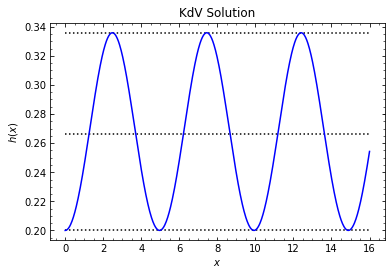

In [48]:
### BEGIN SOLUTION
def KdV_func(x, y) :
    """System of first order differential equations representing the KdV equation.
    Here we choose the ordering for y:
    y[0] = h(x)
    y[1] = g(x) [first derivative of h]
    y[2] = f(x) [second derivative of h]
    """
    dydx = np.zeros_like(y)
    dydx[0] = y[1]
    dydx[1] = y[2]
    dydx[2] = -6.0*y[0]*y[1]
    return dydx


def average_wave_height(tol, plot=False) :
    """Function to return the average wave height, supplying a
    specific tolerance to different routines
    """

    # Initial conditions following the order in KdV_func
    y0 = np.array([0.2, 0.0, 0.1])
    # Range for solution.
    (xmin, xmax) = (0.0, 16.0)
    
    # Solve the KdV equation
    KdV_sol = integ.solve_ivp(KdV_func, (xmin, xmax), y0,
                              vectorized=True, atol=tol, rtol=tol)

    # Spline for the height.
    KdV_interp = interp.InterpolatedUnivariateSpline(KdV_sol.t, KdV_sol.y[0])
    
    # Spline for the derivative.  We will use this to find the extrema.
    # We have seen other ways of doing this.
    KdV_deriv = interp.InterpolatedUnivariateSpline(KdV_sol.t, KdV_sol.y[1])
    
    # Find the extrema.  We do NOT assume x=0 is a minimum.
    max1 = opt.brentq(KdV_deriv, 2, 4, xtol=tol, rtol=tol)
    min1 = opt.brentq(KdV_deriv, 4, 6, xtol=tol, rtol=tol)
    max2 = opt.brentq(KdV_deriv, 6, 8, xtol=tol, rtol=tol)


    hmin = KdV_interp(min1)
    hmax = KdV_interp(max1)

    KdV_integ, err = integ.quad(KdV_interp, max1, max2)
    havg = KdV_integ / (max2-max1)
    
    # Create a simple plot
    if plot:
        plt.plot(KdV_sol.t, KdV_sol.y[0], 'b-')
        plt.hlines(havg, xmin, xmax, linestyles='dotted', label='Average')
        plt.hlines(hmin, xmin, xmax, linestyles='dotted', label='Average')
        plt.hlines(hmax, xmin, xmax, linestyles='dotted', label='Average')
        plt.xlabel("$x$")
        plt.ylabel('$h(x)$')
        plt.title('KdV Solution')
        plt.minorticks_on()
    
    return {
        "hmax": hmax,
        "hmin": hmin,
        "period": max2-max1,
        "havg": havg
    }


# Get the wave properties with two different tolerances
wave11 = average_wave_height(1.0e-11)
wave12 = average_wave_height(1.0e-12, plot=True)

# Compare values, and use the differences as an estimate of the error.
# Note that this is, essentially, an *estimate*, and the true error may
# be much larger.
      
print(f"""
The KdV wave solution properties are as follows:
Wave period: {wave11['period']} +/- {np.abs(wave11['period']-wave12['period'])},
Max wave height: {wave11['hmax']} +/- {np.abs(wave11['hmax']-wave12['hmax'])},
Min wave height: {wave11['hmin']} +/- {np.abs(wave11['hmin']-wave12['hmin'])},
Avg wave height: {wave11['havg']} +/- {np.abs(wave11['havg']-wave12['havg'])}""")

### END SOLUTION

## Member Participation

See Lab 1 for instructions on turning in labs. In the following cell enter the names for each student in the group who partcipated in this lab.